<a href="https://colab.research.google.com/github/arvchak/MLProj/blob/main/protonetwork_efficientnet20_way_20Shot_20Way.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#!pip install tensorflow
#!pip install tensornets

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
import glob
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import os
import pathlib
from PIL import Image
from numpy.linalg import norm
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.imagenet_utils import decode_predictions
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras import layers
from tensorflow.keras.applications import EfficientNetB2
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import models

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/new_train.zip

Streaming output truncated to the last 5000 lines.
  inflating: new_train/val/roundabout/roundabout_196.jpg  
  inflating: new_train/val/roundabout/roundabout_141.jpg  
  inflating: new_train/val/roundabout/roundabout_627.jpg  
  inflating: new_train/val/roundabout/roundabout_633.jpg  
  inflating: new_train/val/roundabout/roundabout_155.jpg  
  inflating: new_train/val/roundabout/roundabout_169.jpg  
  inflating: new_train/val/roundabout/roundabout_151.jpg  
  inflating: new_train/val/roundabout/roundabout_637.jpg  
  inflating: new_train/val/roundabout/roundabout_623.jpg  
  inflating: new_train/val/roundabout/roundabout_145.jpg  
  inflating: new_train/val/roundabout/roundabout_179.jpg  
  inflating: new_train/val/roundabout/roundabout_192.jpg  
  inflating: new_train/val/roundabout/roundabout_186.jpg  
  inflating: new_train/val/roundabout/roundabout_435.jpg  
  inflating: new_train/val/roundabout/roundabout_353.jpg  
  inflating: new_train/val/roundabout/roundabout_347.jpg  
  inf

In [ ]:
root_path = '/content/new_train'
output = '/content/new_train'

In [ ]:
data_dir = pathlib.Path(root_path)
count =  len(list(data_dir.glob('*/*.jpg')))
print(count)

0


In [ ]:
#!pip install split-folders
##import splitfolders
#splitfolders.ratio(root_path , output , seed = 42 , ratio = (.7, .2 ,.1), group_prefix = None)

In [ ]:
data_dir_train = pathlib.Path(output+'/train')
data_dir_test = pathlib.Path(output+'/test')
data_dir_val = pathlib.Path(output+'/val')

In [ ]:
batch_size = 45
img_height = 128
img_width = 128
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train, 
    image_size = (img_height, img_width), 
    batch_size = (batch_size))

Found 23100 files belonging to 33 classes.


In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_val, 
    image_size = (img_height, img_width), 
    batch_size = (batch_size))

Found 8400 files belonging to 12 classes.


In [ ]:
class_names = train_ds.class_names
val_class_names = val_ds.class_names
print(class_names)
no_of_classes = len(class_names)
no_val_classes = len(val_class_names)
#train_np = np.stack(list(train_ds))

['airplane', 'airport', 'baseball_diamond', 'basketball_court', 'beach', 'bridge', 'chaparral', 'church', 'circular_farmland', 'cloud', 'commercial_area', 'dense_residential', 'desert', 'forest', 'freeway', 'golf_course', 'ground_track_field', 'harbor', 'industrial_area', 'intersection', 'island', 'lake', 'meadow', 'medium_residential', 'mobile_home_park', 'mountain', 'overpass', 'palace', 'parking_lot', 'railway', 'storage_tank', 'tennis_court', 'terrace']


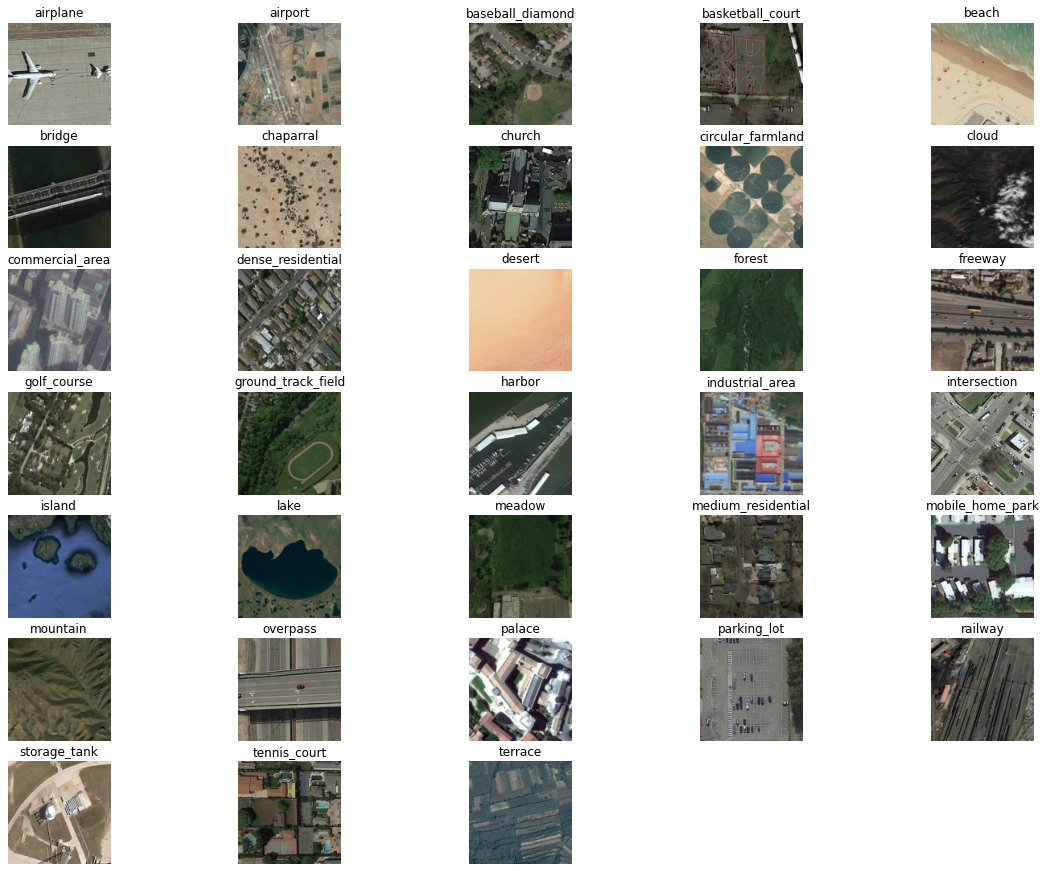

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 20))
j = 0
for i in range(len(class_names)):
    filtered_ds = train_ds.filter(lambda x, l: tf.math.equal(l[0], i))
    for image, label in filtered_ds.take(1):
        ax = plt.subplot(9, 5, i+1)
        plt.imshow(image[0].numpy().astype('uint8'))
        plt.title(class_names[label.numpy()[0]])
        plt.axis('off')

In [ ]:
#train_dataset = np.zeros([no_of_classes, 3, img_height, img_width], dtype=object)
examples = np.zeros([no_of_classes, 700, img_height, img_width,3], dtype=np.float32)
for train in range(len(class_names)):
  filtered_ds = train_ds.filter(lambda x, l: tf.math.equal(l[0], train))
  for image, label in filtered_ds.take(1):
    img_files = sorted(glob.glob(os.path.join(data_dir_train , class_names[label.numpy()[0]], '*.jpg')))
    for index, img_file in enumerate(img_files):
      values =  np.array(Image.open(img_file).resize((img_width, img_height)), np.float32, copy=False)
      examples[label.numpy()[0], index] = values


In [ ]:
test_data = np.zeros([no_val_classes, 700, img_height, img_width,3], dtype=np.float32)
for val in range(len(val_class_names)):
  filtered_val_ds = val_ds.filter(lambda x, l: tf.math.equal(l[0], val))
  for image, label in filtered_val_ds.take(1):
    img_files = sorted(glob.glob(os.path.join(data_dir_val , val_class_names[label.numpy()[0]], '*.jpg')))
    for index, img_file in enumerate(img_files):
      values =  np.array(Image.open(img_file).resize((img_width, img_height)), np.float32, copy=False)
      test_data[label.numpy()[0], index] = values


In [ ]:
sample_img_augmentation = Sequential(
    [
        layers.RandomRotation(factor=0.15),
        layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
        layers.RandomFlip(),
        layers.RandomContrast(factor=0.1),
    ],
    name="img_augmentation",
)


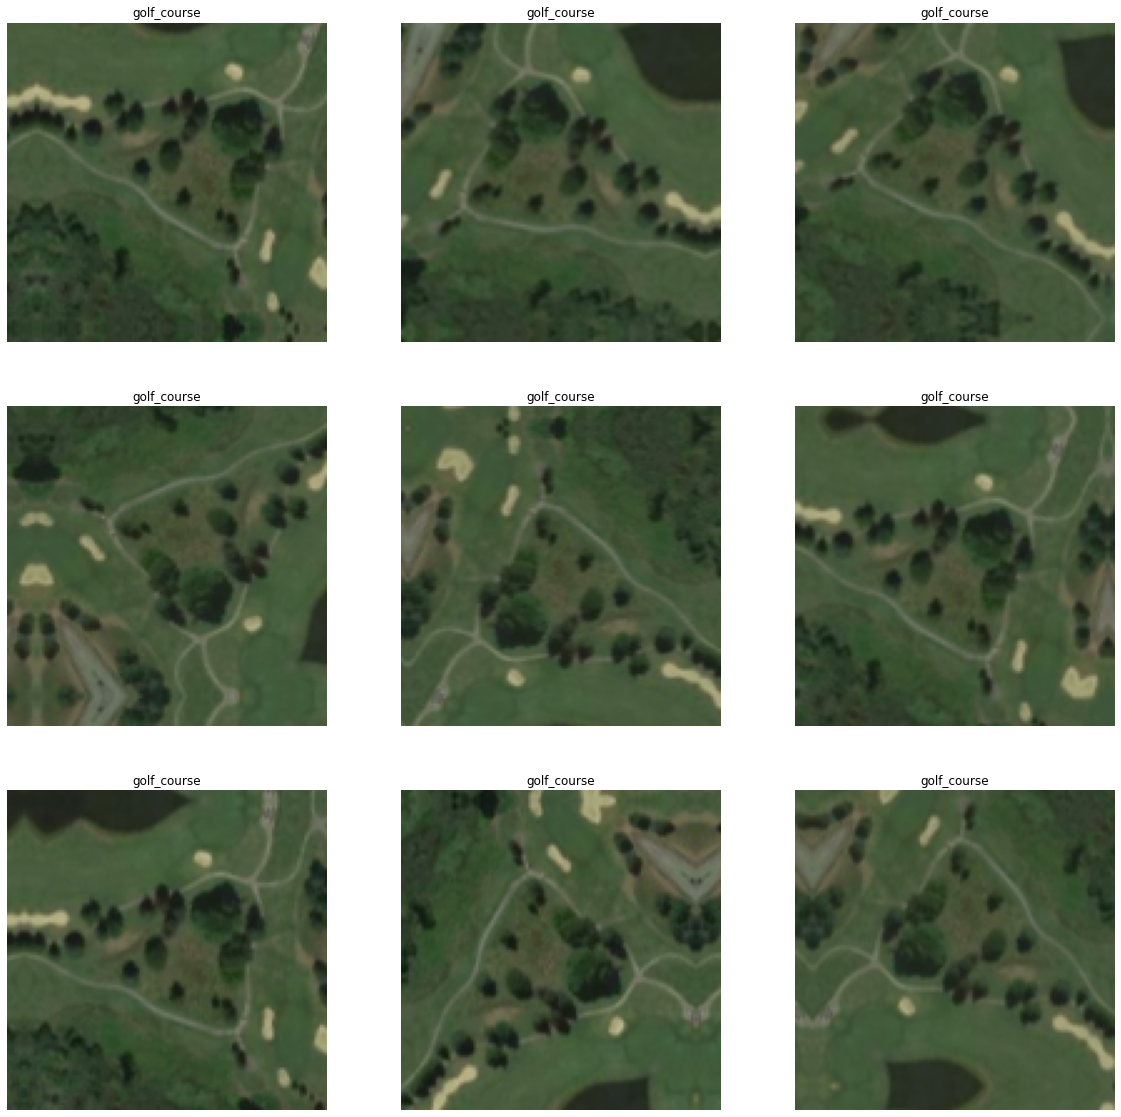

In [ ]:
plt.figure(figsize=(20, 20))
for image, label in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        aug_img = sample_img_augmentation(image)
        plt.imshow(aug_img[0].numpy().astype("uint8"))
        plt.title(class_names[label.numpy()[0]])
        plt.axis("off")

In [ ]:
tf.compat.v1.disable_eager_execution()

In [ ]:
img_augmentation = Sequential(
    [
        layers.RandomRotation(factor=0.15),
        layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
        layers.RandomFlip(),
        layers.RandomContrast(factor=0.1),
    ],
    name="img_augmentation",
)


In [ ]:
def base_model(inputs, h_dim , z_dim):
    layer_inputs = layers.Input(tensor = inputs)
    #x = img_augmentation(inputs)
    x = img_augmentation(layer_inputs)
    model = EfficientNetB0(include_top=False, input_tensor=x, weights="imagenet")

    # Freeze the pretrained weights
    model.trainable = False
       # Rebuild top
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = layers.Flatten()(x)

    net = cnn(inputs, h_dim)
    net = cnn(net, h_dim)
    net = cnn(net, h_dim) 
    net = cnn(net, z_dim) 
    net = tf.keras.layers.Flatten()(net)
    

    # Rebuild top
    return tf.concat([x, net], axis = 1)

In [ ]:
def cnn(inputs, op_channels):
    conv = tf.compat.v1.layers.conv2d(inputs, op_channels, kernel_size=3, padding='SAME')
    conv = tf.compat.v1.layers.batch_normalization(conv,scale=True, center=True)
    conv = tf.nn.swish(conv)
    conv = tf.compat.v1.layers.max_pooling2d(conv, strides = 2, pool_size=2, padding = 'SAME')
    return conv

In [ ]:
#number of classes
num_way = 20

#number of examples per class for support set
num_shot = 5

#number of query points
num_query = 5

#number of examples
num_examples = 70

channel = 3

h_dim = 64

z_dim = 64

In [ ]:
support_set = tf.compat.v1.placeholder(tf.float32, [None, None, img_height, img_width, 3])
query_set = tf.compat.v1.placeholder(tf.float32, [None, None, img_height, img_width, 3])
label = tf.compat.v1.placeholder(tf.int64, [None, None])

In [ ]:
support_set_shape = tf.shape(support_set)
query_set_shape = tf.shape(query_set)


In [ ]:
num_classes, num_support_points = support_set_shape[0], support_set_shape[1]

In [ ]:
num_query_points = query_set_shape[1]

In [ ]:
y = tf.compat.v1.placeholder(tf.int64, [None, None])

#convert the label to one hot
y_one_hot = tf.one_hot(y, depth=num_classes)
print(y_one_hot.shape)


label_prime = tf.one_hot(label , depth = num_classes)

(None, None, None)


In [ ]:
#output = build_model(tf.reshape(support_set, [num_classes * num_support_points, img_height, img_width, channel]))
support_set_embeddings = base_model(tf.reshape(support_set, [num_classes * num_support_points, img_height, img_width, channel]), h_dim, z_dim)

Instructions for updating:
Colocations handled automatically by placer.
16719872/16705208 [==============================] - 0s 0us/step


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `tf.layers.conv2d` is deprecated and will be removed in a future version. Please Use `tf.keras.layers.Conv2D` instead.
  
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/convolutional.py:575: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `tf.layers.batch_normalization` is deprecated and will be removed in a future version. Please use `tf.keras.layers.BatchNormalization` instead. In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.BatchNormalization` documentation).
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/normalization.py:463: UserWarning: `layer.appl

In [ ]:
embedding_dimension = tf.shape(support_set_embeddings)[-1]
class_prototype = tf.reduce_mean(tf.reshape(support_set_embeddings, [num_classes, num_support_points, embedding_dimension]), axis=1)

In [ ]:
#query_output = build_model(tf.reshape(query_set, [num_classes * num_query_points, img_height, img_width, channel]))
query_set_embeddings = base_model(tf.reshape(query_set, [num_classes * num_query_points, img_height, img_width, channel]), h_dim, z_dim)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `tf.layers.conv2d` is deprecated and will be removed in a future version. Please Use `tf.keras.layers.Conv2D` instead.
  
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/convolutional.py:575: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `tf.layers.batch_normalization` is deprecated and will be removed in a future version. Please use `tf.keras.layers.BatchNormalization` instead. In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.BatchNormalization` documentation).
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/normalization.py:463: UserWarning: `layer.appl

In [ ]:
def euclidean_distance(a, b):

    N, D = tf.shape(a)[0], tf.shape(a)[1]
    M = tf.shape(b)[0]
    a = tf.tile(tf.expand_dims(a, axis=1), (1, M, 1))
    b = tf.tile(tf.expand_dims(b, axis=0), (N, 1, 1))
    return tf.reduce_mean(tf.square(a - b), axis=2)
   
    

In [ ]:
print(support_set_embeddings.shape)
print(query_set_embeddings.shape)
print(class_prototype.shape)

distance = euclidean_distance(query_set_embeddings,class_prototype)
print(distance)

predicted_probability = tf.reshape(tf.nn.log_softmax(-distance) , [num_classes, num_query_points, -1])
loss = -tf.reduce_mean(tf.reshape(tf.reduce_sum(tf.multiply(y_one_hot, predicted_probability), axis=-1), [-1]))

accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(predicted_probability, axis=-1), y), tf.float32))

train = tf.compat.v1.train.AdamOptimizer(learning_rate=0.0001).minimize(loss)


(None, 5376)
(None, 5376)
(None, 5376)
Tensor("Mean_1:0", shape=(None, None), dtype=float32)


In [ ]:
sess = tf.compat.v1.InteractiveSession()
init = tf.compat.v1.global_variables_initializer()
saver = tf.compat.v1.train.Saver()
sess.run(init)

In [ ]:
num_epochs = 50
num_episodes = 100
train_accuracy_over_epochs = []
train_loss_over_epochs = []
test_accuracy_over_epochs = []
test_loss_over_epochs = []

In [ ]:
for epoch in range(num_epochs):
    
    for episode in range(num_episodes):
        
        # select 60 classes
        episodic_classes = np.random.permutation(no_of_classes)[:num_way]
        
        support = np.zeros([num_way, num_shot, img_height, img_width, channel], dtype=np.float32)
        
        query = np.zeros([num_way, num_query, img_height, img_width, channel], dtype=np.float32)
        
        
        for index, class_ in enumerate(episodic_classes):
            selected = np.random.permutation(num_examples)[:num_shot + num_query]
            support[index] = examples[class_, selected[:num_shot]]
            
            # 5 querypoints per classs
            query[index] = examples[class_, selected[num_shot:]]
            
        #=support = np.expand_dims(support, axis=-1)
        #query = np.expand_dims(query, axis=-1)
        labels = np.tile(np.arange(num_way)[:, np.newaxis], (1, num_query)).astype(np.uint8)
        _, loss_, accuracy_ = sess.run([train, loss, accuracy], feed_dict={support_set: support, query_set: query, y:labels})
        train_accuracy_over_epochs.append(accuracy_)
        train_loss_over_epochs.append(loss_)
        if (episode+1) % 100 == 0:
            print('Epoch {} : Episode {} : Loss: {}, Accuracy: {}'.format(epoch+1, episode+1, loss_, accuracy_))

Epoch 1 : Episode 100 : Loss: 2.3956546783447266, Accuracy: 0.23000000417232513
Epoch 2 : Episode 100 : Loss: 2.2868099212646484, Accuracy: 0.23000000417232513
Epoch 3 : Episode 100 : Loss: 2.1838369369506836, Accuracy: 0.23999999463558197
Epoch 4 : Episode 100 : Loss: 1.9961884021759033, Accuracy: 0.41999998688697815
Epoch 5 : Episode 100 : Loss: 2.1490061283111572, Accuracy: 0.30000001192092896
Epoch 6 : Episode 100 : Loss: 2.0016536712646484, Accuracy: 0.3400000035762787
Epoch 7 : Episode 100 : Loss: 2.1429290771484375, Accuracy: 0.3199999928474426
Epoch 8 : Episode 100 : Loss: 2.1606333255767822, Accuracy: 0.3100000023841858
Epoch 9 : Episode 100 : Loss: 1.6245323419570923, Accuracy: 0.4699999988079071
Epoch 10 : Episode 100 : Loss: 1.7691636085510254, Accuracy: 0.47999998927116394
Epoch 11 : Episode 100 : Loss: 1.6650335788726807, Accuracy: 0.4399999976158142
Epoch 12 : Episode 100 : Loss: 1.6026310920715332, Accuracy: 0.5299999713897705
Epoch 13 : Episode 100 : Loss: 1.4594984054

In [ ]:

n_test_episodes = 3000
n_test_way = 20
n_test_shot = 5
n_test_query = 5
n_test_classes = test_data.shape[0]


In [ ]:
for test_episode in range(n_test_episodes):
        
        # select 60 classes
        episodic_classes = np.random.permutation(n_test_classes)[:n_test_way]
        
        support = np.zeros([n_test_way, n_test_shot, img_height, img_width, channel], dtype=np.float32)
        
        query = np.zeros([n_test_way, n_test_query, img_height, img_width, channel], dtype=np.float32)
        
        
        for index, class_ in enumerate(episodic_classes):
            selected = np.random.permutation(num_examples)[:n_test_shot + n_test_query]
            support[index] = test_data[class_, selected[:n_test_shot]]
            
            # 5 querypoints per classs
            query[index] = test_data[class_, selected[n_test_shot:]]
            
        #support = np.expand_dims(support, axis=-1)
        #query = np.expand_dims(query, axis=-1)
        labels = np.tile(np.arange(n_test_way)[:, np.newaxis], (1, n_test_query)).astype(np.uint8)
        ls, ac = sess.run([loss, accuracy], feed_dict={support_set: support, query_set: query, y:labels})
        test_accuracy_over_epochs.append(ac)
        test_loss_over_epochs.append(ls)
        if (test_episode+1) % 10 == 0:
            print('Episode {} : Loss: {}, Accuracy: {}'.format(test_episode+1, ls, ac))

Episode 10 : Loss: 2.035325288772583, Accuracy: 0.28999999165534973
Episode 20 : Loss: 1.9786407947540283, Accuracy: 0.3100000023841858
Episode 30 : Loss: 1.9452213048934937, Accuracy: 0.2800000011920929
Episode 40 : Loss: 1.958966851234436, Accuracy: 0.3400000035762787
Episode 50 : Loss: 2.108318567276001, Accuracy: 0.27000001072883606
Episode 60 : Loss: 1.806374192237854, Accuracy: 0.33000001311302185
Episode 70 : Loss: 1.666989803314209, Accuracy: 0.3799999952316284
Episode 80 : Loss: 1.8831590414047241, Accuracy: 0.2800000011920929
Episode 90 : Loss: 1.8632292747497559, Accuracy: 0.2800000011920929
Episode 100 : Loss: 1.8261709213256836, Accuracy: 0.3400000035762787
Episode 110 : Loss: 1.6699392795562744, Accuracy: 0.33000001311302185
Episode 120 : Loss: 1.8239305019378662, Accuracy: 0.3100000023841858
Episode 130 : Loss: 1.729469895362854, Accuracy: 0.3199999928474426
Episode 140 : Loss: 1.8667311668395996, Accuracy: 0.3199999928474426
Episode 150 : Loss: 1.878746509552002, Accura

In [37]:

n_test_episodes = 3000
n_test_way = 20
n_test_shot = 3
n_test_query = 5
n_test_classes = test_data.shape[0]
test1_accuracy_over_epochs = []
for test_episode in range(n_test_episodes):
        
        # select 60 classes
        episodic_classes = np.random.permutation(n_test_classes)[:n_test_way]
        
        support = np.zeros([n_test_way, n_test_shot, img_height, img_width, channel], dtype=np.float32)
        
        query = np.zeros([n_test_way, n_test_query, img_height, img_width, channel], dtype=np.float32)
        
        
        for index, class_ in enumerate(episodic_classes):
            selected = np.random.permutation(num_examples)[:n_test_shot + n_test_query]
            support[index] = test_data[class_, selected[:n_test_shot]]
            
            # 5 querypoints per classs
            query[index] = test_data[class_, selected[n_test_shot:]]
            
        #support = np.expand_dims(support, axis=-1)
        #query = np.expand_dims(query, axis=-1)
        labels = np.tile(np.arange(n_test_way)[:, np.newaxis], (1, n_test_query)).astype(np.uint8)
        ls, ac = sess.run([loss, accuracy], feed_dict={support_set: support, query_set: query, y:labels})
        test1_accuracy_over_epochs.append(ac)
        #test_loss_over_epochs.append(ls)
        if (test_episode+1) % 10 == 0:
            print('Episode {} : Loss: {}, Accuracy: {}'.format(test_episode+1, ls, ac))

Episode 10 : Loss: 2.0852816104888916, Accuracy: 0.23999999463558197
Episode 20 : Loss: 2.427384376525879, Accuracy: 0.2800000011920929
Episode 30 : Loss: 2.0918798446655273, Accuracy: 0.27000001072883606
Episode 40 : Loss: 2.0920844078063965, Accuracy: 0.27000001072883606
Episode 50 : Loss: 1.9970120191574097, Accuracy: 0.3400000035762787
Episode 60 : Loss: 2.175203800201416, Accuracy: 0.23000000417232513
Episode 70 : Loss: 2.0718841552734375, Accuracy: 0.30000001192092896
Episode 80 : Loss: 2.1397924423217773, Accuracy: 0.2800000011920929
Episode 90 : Loss: 2.302191734313965, Accuracy: 0.27000001072883606
Episode 100 : Loss: 2.2419824600219727, Accuracy: 0.25999999046325684
Episode 110 : Loss: 2.0682923793792725, Accuracy: 0.2199999988079071
Episode 120 : Loss: 2.1037118434906006, Accuracy: 0.27000001072883606
Episode 130 : Loss: 2.004901885986328, Accuracy: 0.27000001072883606
Episode 140 : Loss: 2.3334686756134033, Accuracy: 0.28999999165534973
Episode 150 : Loss: 2.174543380737304

In [38]:
n_test_episodes = 3000
n_test_way = 20
n_test_shot = 1
n_test_query = 5
n_test_classes = test_data.shape[0]
test2_accuracy_over_epochs = []
for test_episode in range(n_test_episodes):
        
        # select 60 classes
        episodic_classes = np.random.permutation(n_test_classes)[:n_test_way]
        
        support = np.zeros([n_test_way, n_test_shot, img_height, img_width, channel], dtype=np.float32)
        
        query = np.zeros([n_test_way, n_test_query, img_height, img_width, channel], dtype=np.float32)
        
        
        for index, class_ in enumerate(episodic_classes):
            selected = np.random.permutation(num_examples)[:n_test_shot + n_test_query]
            support[index] = test_data[class_, selected[:n_test_shot]]
            
            # 5 querypoints per classs
            query[index] = test_data[class_, selected[n_test_shot:]]
            
        #support = np.expand_dims(support, axis=-1)
        #query = np.expand_dims(query, axis=-1)
        labels = np.tile(np.arange(n_test_way)[:, np.newaxis], (1, n_test_query)).astype(np.uint8)
        ls, ac = sess.run([loss, accuracy], feed_dict={support_set: support, query_set: query, y:labels})
        test2_accuracy_over_epochs.append(ac)
        if (test_episode+1) % 10 == 0:
            print('Episode {} : Loss: {}, Accuracy: {}'.format(test_episode+1, ls, ac))

Episode 10 : Loss: 3.4879913330078125, Accuracy: 0.20000000298023224
Episode 20 : Loss: 3.2902581691741943, Accuracy: 0.20999999344348907
Episode 30 : Loss: 3.5433297157287598, Accuracy: 0.17000000178813934
Episode 40 : Loss: 3.9459328651428223, Accuracy: 0.17000000178813934
Episode 50 : Loss: 3.031696081161499, Accuracy: 0.1899999976158142
Episode 60 : Loss: 3.336883306503296, Accuracy: 0.14000000059604645
Episode 70 : Loss: 3.3628110885620117, Accuracy: 0.2199999988079071
Episode 80 : Loss: 3.79489803314209, Accuracy: 0.18000000715255737
Episode 90 : Loss: 3.9150002002716064, Accuracy: 0.20999999344348907
Episode 100 : Loss: 2.545769691467285, Accuracy: 0.25999999046325684
Episode 110 : Loss: 4.1787590980529785, Accuracy: 0.1899999976158142
Episode 120 : Loss: 3.706662654876709, Accuracy: 0.20000000298023224
Episode 130 : Loss: 2.9013779163360596, Accuracy: 0.1599999964237213
Episode 140 : Loss: 2.930058479309082, Accuracy: 0.2800000011920929
Episode 150 : Loss: 3.4764513969421387, A

In [39]:
sess.close()

In [40]:
np.mean(train_accuracy_over_epochs[::100])

0.49

In [41]:
import math 
Z = 1.960
N = 3000
mean = np.mean(test_accuracy_over_epochs)
SE = np.std(test_accuracy_over_epochs) / len(test_accuracy_over_epochs)
confidence = Z * (SE * math.sqrt(N))
print(str(mean)+"+/-"+str(confidence))

0.30237332+/-0.0013456608028067588


In [42]:
Z = 1.960
N = 3000
mean = np.mean(test1_accuracy_over_epochs)
SE = np.std(test1_accuracy_over_epochs) / len(test1_accuracy_over_epochs)
confidence = Z * (SE * math.sqrt(N))
print(str(mean)+"+/-"+str(confidence))

0.27464998+/-0.0014143772417456988


In [43]:
Z = 1.960
N = 3000
mean = np.mean(test2_accuracy_over_epochs)
SE = np.std(test2_accuracy_over_epochs) / len(test2_accuracy_over_epochs)
confidence = Z * (SE * math.sqrt(N))
print(str(mean)+"+/-"+str(confidence))

0.18912+/-0.0012831767701930383


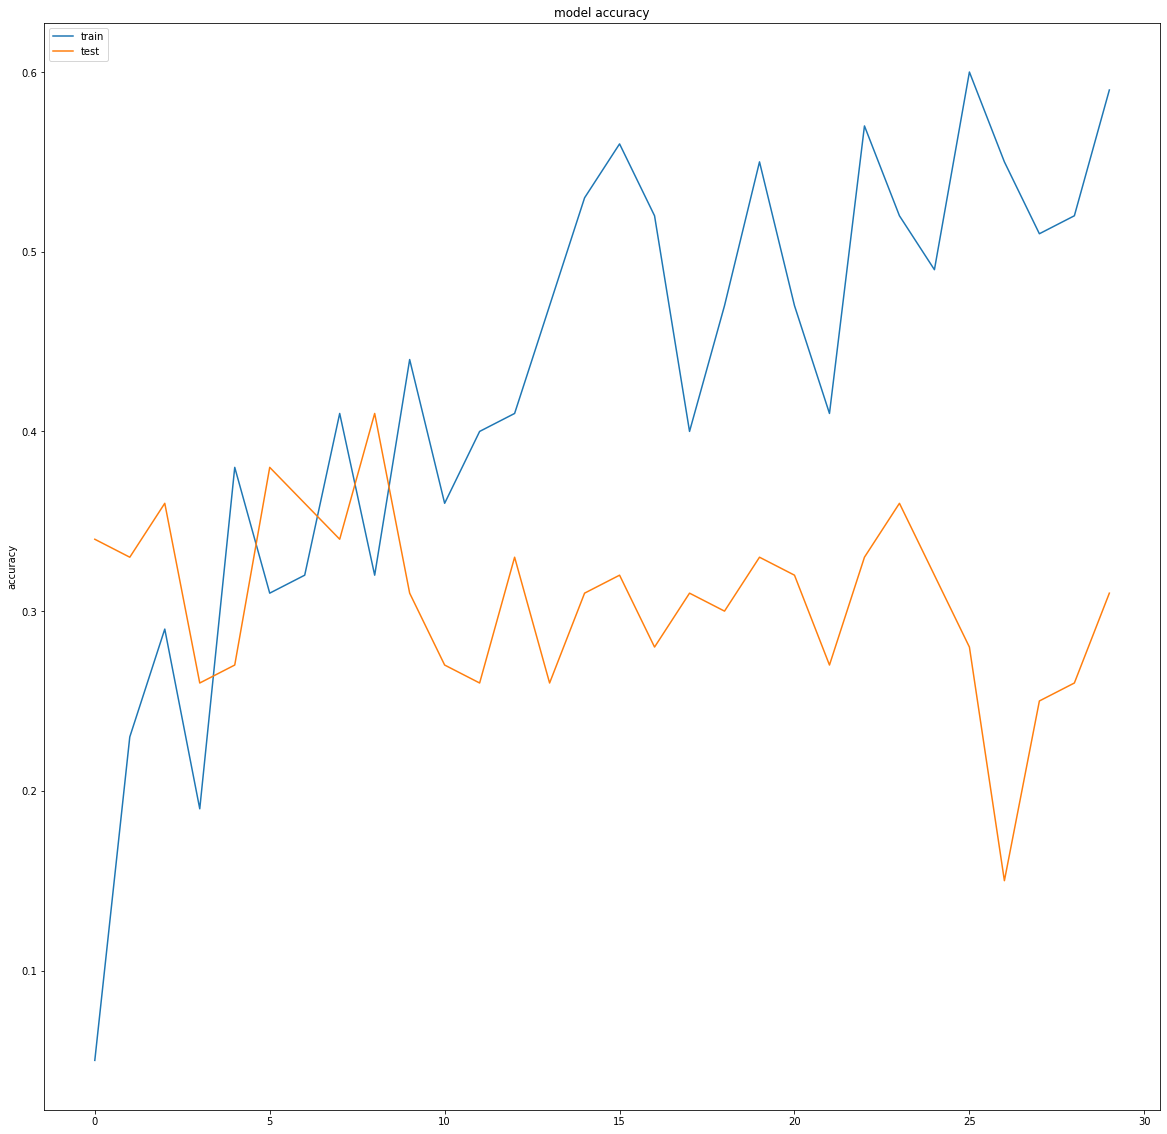

In [44]:
plt.figure(figsize=(20, 20))

plt.plot(train_accuracy_over_epochs[0:3000:100])
plt.plot(test_accuracy_over_epochs[0::100])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [45]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 9095328673416750015
 xla_global_id: -1, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14465892352
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 10618498613063710440
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
 xla_global_id: 416903419]

In [46]:
!cat /proc/meminfo

MemTotal:       53478908 kB
MemFree:        34398632 kB
MemAvailable:   43764156 kB
Buffers:          167148 kB
Cached:          7942408 kB
SwapCached:            0 kB
Active:          9519536 kB
Inactive:        8867476 kB
Active(anon):    8631992 kB
Inactive(anon):    43516 kB
Active(file):     887544 kB
Inactive(file):  8823960 kB
Unevictable:           0 kB
Mlocked:               0 kB
SwapTotal:             0 kB
SwapFree:              0 kB
Dirty:               668 kB
Writeback:             0 kB
AnonPages:      10277196 kB
Mapped:          1800516 kB
Shmem:             44228 kB
KReclaimable:     283260 kB
Slab:             413720 kB
SReclaimable:     283260 kB
SUnreclaim:       130460 kB
KernelStack:        8592 kB
PageTables:        33232 kB
NFS_Unstable:          0 kB
Bounce:                0 kB
WritebackTmp:          0 kB
CommitLimit:    26739452 kB
Committed_AS:   14742524 kB
VmallocTotal:   34359738367 kB
VmallocUsed:       54896 kB
VmallocChunk:          0 kB
Percpu:          